In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from skrub import GapEncoder
from skrub import Cleaner, TableReport

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from qto_categorizer_ml.io import datasets

# Notes constats

- Nombre de transaction baisse en fin d'année 2024 
- 

## Load datasets

In [3]:
path = "../data/data-products.csv"

dtypes = {
    'TRANSACTION_ID': str,
    'AMOUNT': float,
    'TYPE_OF_PAYMENT': str,
    'MERCHANT_NAME': str,
    'DESCRIPTION': str,
    'SIDE':  int,
    'CATEGORY': str,
}
parse_dates = ['DATE_EMITTED']

df = datasets.CSVReader(path=path, dtypes=dtypes, parse_dates=parse_dates).read()
print(f'Volumetrie des données & nombre de transactions: {df.TRANSACTION_ID.shape[0]}') # transactions sont bien unique, ~340k transactions
df[['AMOUNT', 'TYPE_OF_PAYMENT', 'MERCHANT_NAME', 'DESCRIPTION', 'CATEGORY']].head()

Volumetrie des données & nombre de transactions: 337237


,AMOUNT,TYPE_OF_PAYMENT,MERCHANT_NAME,DESCRIPTION,CATEGORY
0,2187.72,Transfer,FACILECOMM,PRLV FACILECOMM SAS 2414822G10219163,Bank Fees & Charges: Subscription Fees
1,4.94,Direct Debit,GOOGLE CLOUD FRANCE,PRLV SEPA GOOGLE CLOUD FRANCE S GG103JLMOS CLO...,Technology Expenses: Hosting Services
2,3.77,Transfer,AMPEVINO,LES VOUTES - FA00003482 - AMPEVINO,Food & Beverage Expenses
3,130.87,Credit Card,LECLERC,NaN,Operational Expenses: Other Operational Expenses
4,4582.19,Direct Debit,LEODIS ACHAT BOISSONS,EFFETS DOMICILIES DOMICILIES,Food & Beverage Expenses


### Quick Table Report (using skrub package)

In [15]:
Cleaner().fit_transform(df)
TableReport(df)

# Quick remarks: missing values for TYPE_OF_PAYMENT, MERCHANT_NAME, DESCRIPTION variables
# Lien entre TYPE OF PAYMENT et MERCHANT NAME + CATEGORY ET MERCHAND NAME

Processing column   8 / 8


,,,,,,,,


## Analyse des données
### Analyse unitaires des données

In [72]:
# Cash category in TYPE_OF_PAYMENT variable doesnot exist in last month Sept 2024
# df[(df.MONTH==9) & (df.YEAR==2023)][['YEAR', 'MONTH','TYPE_OF_PAYMENT']].value_counts()
# df[(df.MONTH==9) & (df.YEAR==2024)][['YEAR', 'MONTH','TYPE_OF_PAYMENT']].value_counts()


In [ ]:
df[(df.YEAR==2024) & (df.MONTH==9)].DATE_EMITTED.sort_values().unique() # 2023 toutes les transaction, en 2024 uniquement jusque 18 septembre (pour le mois de septembre)


<DatetimeArray>
['2024-09-01 00:00:00', '2024-09-02 00:00:00', '2024-09-03 00:00:00',
 '2024-09-04 00:00:00', '2024-09-05 00:00:00', '2024-09-06 00:00:00',
 '2024-09-07 00:00:00', '2024-09-08 00:00:00', '2024-09-09 00:00:00',
 '2024-09-10 00:00:00', '2024-09-11 00:00:00', '2024-09-12 00:00:00',
 '2024-09-13 00:00:00', '2024-09-14 00:00:00', '2024-09-15 00:00:00',
 '2024-09-16 00:00:00', '2024-09-17 00:00:00', '2024-09-18 00:00:00']
Length: 18, dtype: datetime64[ns]

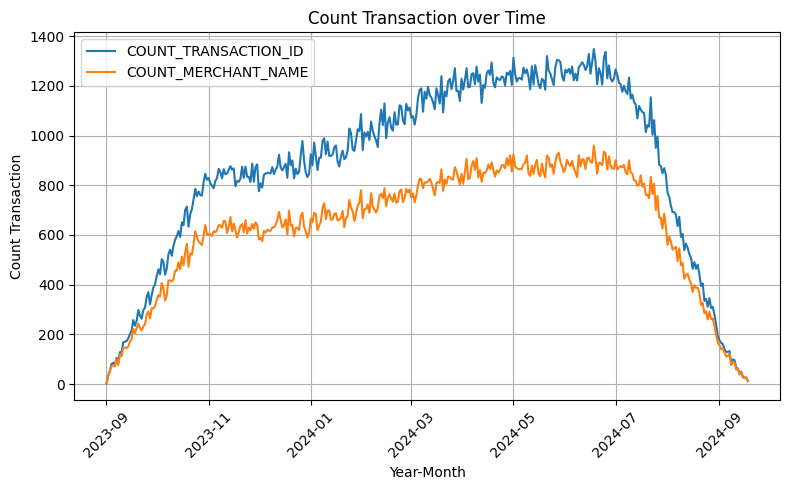

In [137]:
df['YEAR'], df['MONTH'], df['DAY'] = df['DATE_EMITTED'].dt.year, df['DATE_EMITTED'].dt.month, df['DATE_EMITTED'].dt.day
df['YEAR_MONTH'] = df['YEAR'].astype(str) + df['MONTH'].astype(str)

df_grouped_by_year_month = df\
    .groupby(['DATE_EMITTED'])\
    .agg({'TRANSACTION_ID': pd.Series.nunique, 'CATEGORY': pd.Series.nunique, 'TYPE_OF_PAYMENT': pd.Series.nunique, 'MERCHANT_NAME': pd.Series.nunique})\
    .rename(columns={'TRANSACTION_ID': 'COUNT_TRANSACTION_ID', 'CATEGORY': 'COUNT_CATEGORY', 'TYPE_OF_PAYMENT': 'COUNT_TYPE_OF_PAYMENT', 'MERCHANT_NAME': 'COUNT_MERCHANT_NAME'})\
    .reset_index()

plt.figure(figsize=(8, 5))
plt.plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_TRANSACTION_ID'])
# plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_CATEGORY']) # number of category change over time (between 40 and 42 category) -> new category or not?
# plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_TYPE_OF_PAYMENT']) # Cash category doesnot exist in last month Sept 2024
plt.plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_MERCHANT_NAME']) 
plt.xlabel('Year-Month')
plt.ylabel('Count Transaction')
plt.title('Count Transaction over Time')
plt.legend(['COUNT_TRANSACTION_ID','COUNT_MERCHANT_NAME'])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


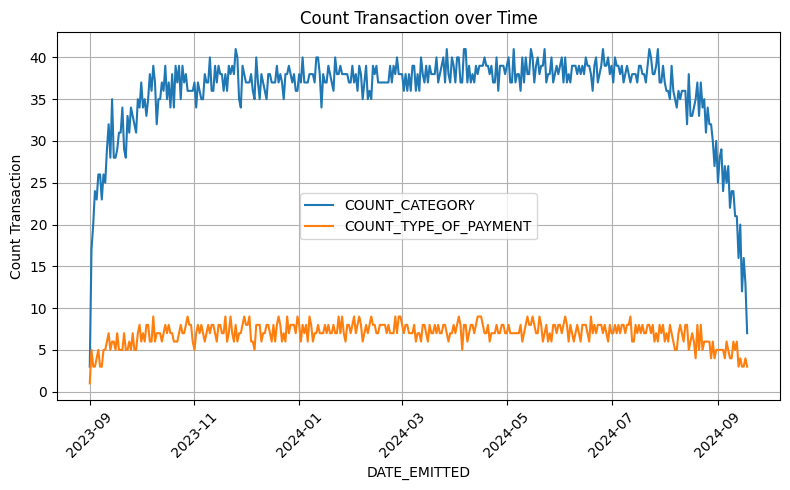

In [139]:
plt.figure(figsize=(8, 5))
plt.plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_CATEGORY']) # number of category change over time (between 40 and 42 category) -> new category or not?
plt.plot(df_grouped_by_year_month['DATE_EMITTED'], df_grouped_by_year_month['COUNT_TYPE_OF_PAYMENT']) # Cash category doesnot exist in last month Sept 2024
plt.xlabel('DATE_EMITTED')
plt.ylabel('Count Transaction')
plt.title('Count Transaction over Time')
plt.legend(['COUNT_CATEGORY','COUNT_TYPE_OF_PAYMENT'])
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

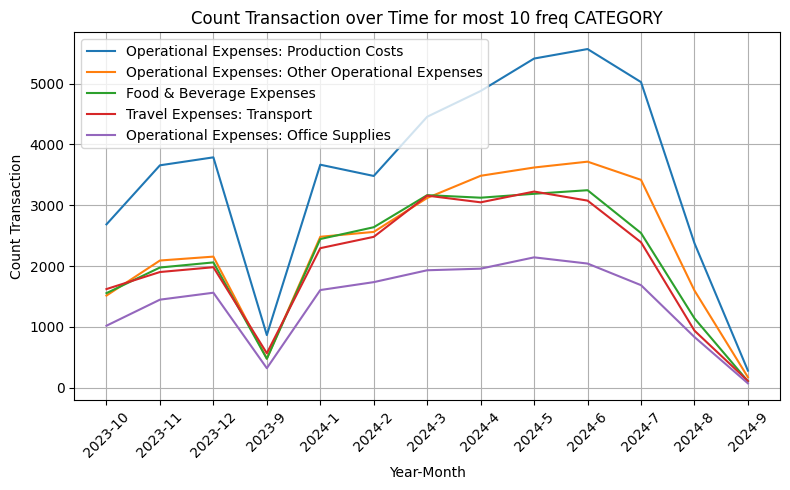

In [124]:
# Evolution de quelques categories 
CATEGORIES = df.CATEGORY.value_counts().index[:5]

plt.figure(figsize=(8, 5))
for CATEGORY in CATEGORIES:
    tmp = df[df.CATEGORY == CATEGORY]
    df_grouped_by_year_month = tmp\
        .groupby(['YEAR_MONTH'])\
        .agg({'TRANSACTION_ID': pd.Series.nunique, 'CATEGORY': pd.Series.nunique, 'TYPE_OF_PAYMENT': pd.Series.nunique, 'MERCHANT_NAME': pd.Series.nunique})\
        .rename(columns={'TRANSACTION_ID': 'COUNT_TRANSACTION_ID', 'MERCHANT_NAME': 'COUNT_MERCHANT_NAME'})\
        .reset_index()

    plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_TRANSACTION_ID']) 
    # plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_MERCHANT_NAME']) 

plt.xlabel('Year-Month')
plt.ylabel('Count Transaction')
plt.title(f'Count Transaction over Time for most 10 freq CATEGORY')
plt.legend(CATEGORIES)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

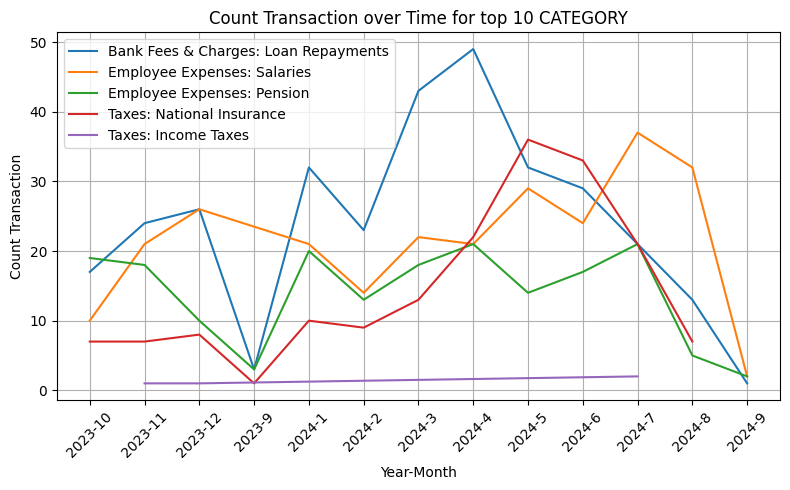

In [ ]:
# Evolution de quelques categories 
CATEGORIES = df.CATEGORY.value_counts().index[-5:]

plt.figure(figsize=(8, 5))
for CATEGORY in CATEGORIES:
    tmp = df[df.CATEGORY == CATEGORY]
    df_grouped_by_year_month = tmp\
        .groupby(['YEAR_MONTH'])\
        .agg({'TRANSACTION_ID': pd.Series.nunique, 'CATEGORY': pd.Series.nunique, 'TYPE_OF_PAYMENT': pd.Series.nunique, 'MERCHANT_NAME': pd.Series.nunique})\
        .rename(columns={'TRANSACTION_ID': 'COUNT_TRANSACTION_ID', 'MERCHANT_NAME': 'COUNT_MERCHANT_NAME'})\
        .reset_index()

    plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_TRANSACTION_ID']) 
    # plt.plot(df_grouped_by_year_month['YEAR_MONTH'], df_grouped_by_year_month['COUNT_MERCHANT_NAME']) 

plt.xlabel('Year-Month')
plt.ylabel('Count Transaction')
plt.title(f'Count Transaction over Time for less 10 freq CATEGORY')
plt.legend(CATEGORIES)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

In [ ]:
# Analyse unitaire: 
# Periode (time):
# - Nombre de transaction par mois ? semaine ? année

# Analyse croisée 
# -> Features
# - Y a til de nouvelle catagories qui arrivent au court du temps ?
# - Les categories ont-il un bon formating? (doublons, espace, minuscule, etc)
# - Nombre de transaction par année et type de payment?
# - Top 5 marchants 
# -> Cible
# - Filtre par category les plus récuperentes (ex. 5)
# - Filtre par category les moins récuperentes (ex. 5)
# - wordcloud par labels 
# marchand qui couvrent 1 et d'autres qui couvrent plusieurs labels



(337237,)

In [ ]:
## Analyse unitaire des variables
id = ["TRANSACTION_ID"]
date_variables = ["DATE_EMITTED"]
categorial_variables = ["TYPE_OF_PAYMENT", "MERCHANT_NAME", "DESCRIPTION", "SIDE"]
numerical_variables = ['AMOUNT']
target = ["CATEGORY"]


## Analyse croisée


In [ ]:
## Est-ce que mes classes sont désiquilibré? 

df.CATEGORY.value_counts()
# quelle serait la baseline? 46132
# - classer systematiquement dans 'Operational Expenses: Production Costs': 46132/337237
print(f"Accuracy baseline: {46132/337237 * 100}") # ~14%

Accuracy baseline: 13.679400540272866


In [30]:
# Convert DATE_EMITTED to datetime and extract features
df['DATE_EMITTED'] = pd.to_datetime(df['DATE_EMITTED'])
df['YEAR'] = df['DATE_EMITTED'].dt.year
df['MONTH'] = df['DATE_EMITTED'].dt.month
df['DAY'] = df['DATE_EMITTED'].dt.day

# Drop the original DATE_EMITTED and TRANSACTION_ID columns
df = df.drop(columns=['DATE_EMITTED', 'TRANSACTION_ID'])

df.head()

,AMOUNT,TYPE_OF_PAYMENT,MERCHANT_NAME,DESCRIPTION,SIDE,CATEGORY,YEAR,MONTH,DAY
0,2187.72,Transfer,FACILECOMM,PRLV FACILECOMM SAS 2414822G10219163,0,Bank Fees & Charges: Subscription Fees,2024,6,13
1,4.94,Direct Debit,GOOGLE CLOUD FRANCE,PRLV SEPA GOOGLE CLOUD FRANCE S GG103JLMOS CLO...,0,Technology Expenses: Hosting Services,2024,4,20
2,3.77,Transfer,AMPEVINO,LES VOUTES - FA00003482 - AMPEVINO,0,Food & Beverage Expenses,2024,7,10
3,130.87,Credit Card,LECLERC,NaN,0,Operational Expenses: Other Operational Expenses,2023,10,22
4,4582.19,Direct Debit,LEODIS ACHAT BOISSONS,EFFETS DOMICILIES DOMICILIES,0,Food & Beverage Expenses,2024,4,9


In [ ]:
# Most Frequent baseline Model

df[df.MERCHANT_NAME == "FACILECOMM"].CATEGORY.value_counts() #'GOOGLE CLOUD FRANCE'

merchant_label_counts = df.groupby(['MERCHANT_NAME', 'CATEGORY']).size().reset_index(name='count')
most_frequent = merchant_label_counts.sort_values('count', ascending=False).drop_duplicates("MERCHANT_NAME")
result = most_frequent[['MERCHANT_NAME', "CATEGORY"]].rename(columns={'CATEGORY': 'MOST_FREQUENT_CATEGORY'})
result

y_true = df.CATEGORY
y_pred = df.merge(result, on='MERCHANT_NAME', how='left').MOST_FREQUENT_CATEGORY
from sklearn.metrics import accuracy_score
(y_true == y_pred).value_counts()
262121/(262121+75116)*100 # ~ 78%


77.7260502258056

In [ ]:
df.TYPE_OF_PAYMENT.value_counts()


TYPE_OF_PAYMENT
Transfer                                        222023
Credit Card                                      72896
Direct Debit                                     30866
Bill of Exchange                                  1775
Check                                             1728
Transfer (outside Regate but still transfer)       782
Paypal                                             319
Other                                              261
Cash                                               162
Name: count, dtype: int64

In [10]:
enc = GapEncoder(n_components=10, random_state=0)
enc.fit(df.MERCHANT_NAME)
enc.get_feature_names_out()

['MERCHANT_NAME: odpowiedzialnością, edjekouane, clickandboat',
 'MERCHANT_NAME: totalenergies, totalenergie, ginglinger',
 'MERCHANT_NAME: demenagements, equipements, immobiliere',
 'MERCHANT_NAME: restaurant, restaur, restaurante',
 'MERCHANT_NAME: technologique, technology, astechotel',
 'MERCHANT_NAME: restaurantdivers, carburants, fdivers',
 'MERCHANT_NAME: l4qaconsulting, constructions, infopromotions',
 'MERCHANT_NAME: 401carrefour, chargeking, compagnie',
 'MERCHANT_NAME: mammafiore, services, business',
 'MERCHANT_NAME: transporte, transports, transport']

In [25]:
df = df + enc.transform(df.MERCHANT_NAME)
df.head()

,AMOUNT,CATEGORY,DAY,DESCRIPTION,MERCHANT_NAME,"MERCHANT_NAME: 401carrefour, chargeking, compagnie","MERCHANT_NAME: demenagements, equipements, immobiliere","MERCHANT_NAME: l4qaconsulting, constructions, infopromotions","MERCHANT_NAME: mammafiore, services, business","MERCHANT_NAME: odpowiedzialnością, edjekouane, clickandboat","MERCHANT_NAME: restaurant, restaur, restaurante","MERCHANT_NAME: restaurantdivers, carburants, fdivers","MERCHANT_NAME: technologique, technology, astechotel","MERCHANT_NAME: totalenergies, totalenergie, ginglinger","MERCHANT_NAME: transporte, transports, transport",MONTH,SIDE,TYPE_OF_PAYMENT,YEAR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'DataFrameGroupBy Plot'}>

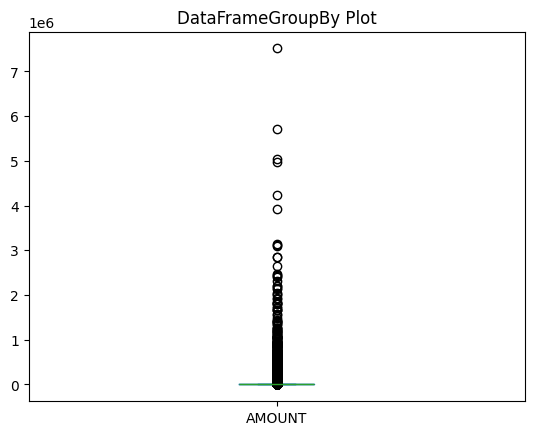

In [ ]:
# AMOUNT??
df[df['AMOUNT']<1000].plot(kind="box", title="DataFrameGroupBy Plot") # bcp de petite transactions et quelques 

In [ ]:
# 50% des transactions < 50€, 80% <1000, 90% <4000
df[df['AMOUNT']<20]['AMOUNT'].shape[0]/337237, df[df['AMOUNT']<50]['AMOUNT'].shape[0]/337237, df[df['AMOUNT']<1000]['AMOUNT'].shape[0]/337237, df[df['AMOUNT']<4000]['AMOUNT'].shape[0]/337237, df.shape

(0.45124348751768045,
 0.5019289105287973,
 0.7926562032042748,
 0.9041415977487642,
 (337237, 12))

<Axes: ylabel='Frequency'>

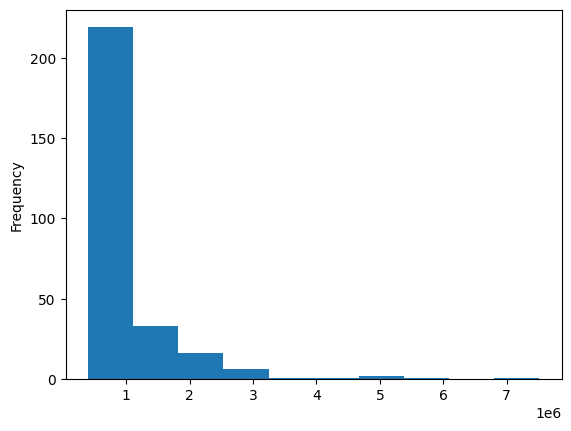

In [203]:
df[df['AMOUNT']>400000]['AMOUNT'].plot(kind='hist')

In [29]:
# discretizer la variable?
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

kdb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['AMOUNT_DISCRET_10_QUANTILE'] = kdb.fit_transform(df[['AMOUNT']]).ravel()

/Users/z424by/Documents/_dev/perso/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [30]:
Cleaner().fit_transform(df)
TableReport(df)

Processing column  10 / 10


,,,,,,,,,,


In [31]:
df.AMOUNT_DISCRET_10_QUANTILE.value_counts()

AMOUNT_DISCRET_10_QUANTILE
2.0    67608
4.0    67586
1.0    67553
3.0    67336
0.0    67154
Name: count, dtype: int64

In [32]:
for i in df.AMOUNT_DISCRET_10_QUANTILE.sort_values().unique():
    print(i, df[df.AMOUNT_DISCRET_10_QUANTILE==i]['AMOUNT'].min(), df[df.AMOUNT_DISCRET_10_QUANTILE==i]['AMOUNT'].max())

0.0 0.01 2.89
1.0 2.9 4.84
2.0 4.85 154.99
3.0 155.0 1079.71
4.0 1079.73 7511743.15


In [33]:
# calculer les proportions? 
for i in df.AMOUNT_DISCRET_10_QUANTILE.sort_values().unique():
    print(i, df[df.AMOUNT_DISCRET_10_QUANTILE == i].AMOUNT.min(), df[df.AMOUNT_DISCRET_10_QUANTILE == i].AMOUNT.max(), '---')
    print(df[df.AMOUNT_DISCRET_10_QUANTILE == i].CATEGORY.value_counts().head(5))

0.0 0.01 2.89 ---
CATEGORY
Operational Expenses: Production Costs              8935
Operational Expenses: Other Operational Expenses    5907
Travel Expenses: Transport                          5682
Food & Beverage Expenses                            5544
Operational Expenses: Office Supplies               3667
Name: count, dtype: int64
1.0 2.9 4.84 ---
CATEGORY
Operational Expenses: Production Costs              9263
Operational Expenses: Other Operational Expenses    5899
Food & Beverage Expenses                            5723
Travel Expenses: Transport                          5649
Operational Expenses: Office Supplies               3710
Name: count, dtype: int64
2.0 4.85 154.99 ---
CATEGORY
Food & Beverage Expenses                            8903
Travel Expenses: Transport                          8758
Operational Expenses: Production Costs              5956
Operational Expenses: Office Supplies               4645
Operational Expenses: Other Operational Expenses    4475
Name: count

In [ ]:
# TODO: barplot de : Food & Beverage Expenses (decrease) and Employee Expenses: Sub-contractors ?  (ou top du premier et du dernier)